In [ ]:
!pip install -q numpy pandas matplotlib seaborn 
!pip install -q torchvision

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import copy
import time
import os
import pickle
import importlib
import pandas as pd



In [2]:
# Utility functions for saving and loading models
# will use to cache experiments to avoid retraining models and to allow reproducible results
def save_model(model, filename, directory='saved_models'):
    """Save a model to disk
    Args:
        model: The model to save
        filename: Name of the file (will add .pkl if not present)
        directory: Directory to save in (will be created if it doesn't exist)
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    filepath = os.path.join(directory, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath}")
    
def load_model(filename, directory='saved_models'):
    """Load a model from disk
    Args:
        filename: Name of the file (will add .pkl if not present)
        directory: Directory to load from
    Returns:
        The loaded model
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
        
    filepath = os.path.join(directory, filename)
    if not os.path.exists(filepath):
        print(f"No saved model found at {filepath}")
        return None
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {filepath}")
    return model

In [3]:
# find mean & std for train_dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
loader_iter = iter(loader)
images, _ = next(loader_iter)
mean_train = images.mean().item()
std_train = images.std().item()
print((mean_train, std_train))

(0.28604060411453247, 0.3530242443084717)


## 3.6: CNN Using Pytorch

### CNN-specific Data Transformation

In [33]:
# Create CNN-specific transforms
cnn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

full_train_cnn = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform)
test_dataset_cnn = datasets.FashionMNIST(root='./data', train=False, download=True, transform=cnn_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn))
val_size = len(full_train_cnn) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn, val_dataset_cnn = random_split(full_train_cnn, [train_size, val_size], generator=generator)

# create dataloaders
batch_size = 64
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True, generator=generator)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)

# sanity check
x_cnn, y_cnn = next(iter(train_loader_cnn))
print((x_cnn.shape, y_cnn.shape)) # expect [64, 1, 28, 28] and [64]

(torch.Size([64, 1, 28, 28]), torch.Size([64]))


### CCN Class

In [24]:
## Import CNN implementation from cnn.py
import cnn                
importlib.reload(cnn)     # reloads the module from disk
from cnn import CNN

# Device (use GPU if available but don't change MLP behavior)
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Using device:', device)

Using device: mps


### CNN Hyperparameter Tuning

#### Learning Rates

In [27]:
# comparison of learning rates
lrs = [0.001, 0.005, 0.01, 0.05, 0.1]

# Initialize empty DataFrame
columns = ["LR", "Validation Loss", "Validation Accuracy"]
df = pd.DataFrame()

for lr in lrs:
    cnn_model = load_model(f'cnn_model_lr_{lr}')

    if cnn_model is None:
        cnn_model = CNN().to(device)
        optimizer = optim.Adam(cnn_model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
        cnn_model.train_cnn(10, optimizer, loss_fn, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)
        save_model(cnn_model, f'cnn_model_lr_{lr}')
    
    validation_loss = cnn_model.val_losses_cnn[-1]
    validation_accuracy = cnn_model.val_accuracies_cnn[-1]

    new_row = pd.DataFrame([[lr, validation_loss, validation_accuracy]], columns=columns)
    df = pd.concat([df, new_row], ignore_index=True)

# table comparison of learning rates
print(df)

Model loaded from saved_models/cnn_model_lr_0.001.pkl
Model loaded from saved_models/cnn_model_lr_0.005.pkl
Model loaded from saved_models/cnn_model_lr_0.01.pkl
Model loaded from saved_models/cnn_model_lr_0.05.pkl
Model loaded from saved_models/cnn_model_lr_0.1.pkl
      LR  Validation Loss  Validation Accuracy
0  0.001         0.597426             0.924417
1  0.005         0.491892             0.893500
2  0.010         0.385755             0.878583
3  0.050         2.311386             0.098667
4  0.100         2.308781             0.096500


Model loaded from saved_models/cnn_model_lr_0.001.pkl
Model loaded from saved_models/cnn_model_lr_0.005.pkl
Model loaded from saved_models/cnn_model_lr_0.01.pkl
Model loaded from saved_models/cnn_model_lr_0.05.pkl
Model loaded from saved_models/cnn_model_lr_0.1.pkl


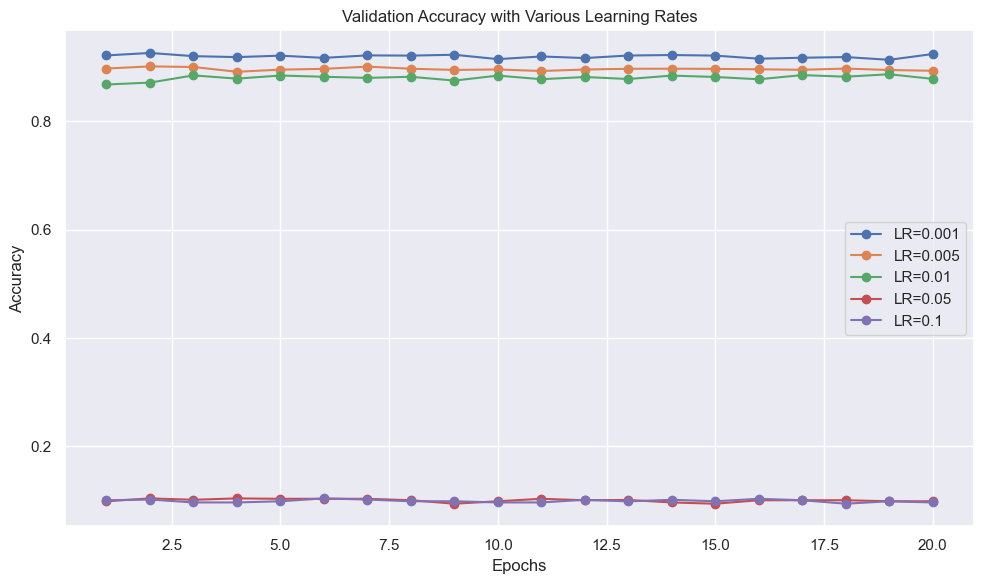

In [47]:
plt.figure(figsize=(10, 6))
clipped_lrs = [0.001, 0.005, 0.01]
for lr in lrs:
    cnn_model = load_model(f'cnn_model_lr_{lr}')
    epochs = range(1, len(cnn_model.val_losses_cnn) + 1)
    plt.plot(epochs, cnn_model.val_accuracies_cnn, marker='o', label=f'LR={lr}')

plt.title('Validation Accuracy with Various Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


#### Batch size

In [ ]:
# create dataloaders
batch_sizes = [32, 64, 128]

# Initialize empty DataFrame
columns = ["Batch Size", "Validation Loss", "Validation Accuracy"]
df = pd.DataFrame()


for batch_size in batch_sizes:
    train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True, generator=generator)
    val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)
    test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)

    cnn_model = load_model(f'cnn_model_batch_{batch_size}')

    if cnn_model is None:
        learning_rate = 0.001
        cnn_model = CNN().to(device)
        optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
        loss_fn = nn.CrossEntropyLoss()
        cnn_model.train_cnn(20, optimizer, loss_fn, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)
        save_model(cnn_model, f'cnn_model_batch_{batch_size}')
    
    validation_loss = cnn_model.val_losses_cnn[-1]
    validation_accuracy = cnn_model.val_accuracies_cnn[-1]

    new_row = pd.DataFrame([[batch_size, validation_loss, validation_accuracy]], columns=columns)
    df = pd.concat([df, new_row], ignore_index=True)

# table comparison of learning rates
print(df)

Model loaded from saved_models/cnn_model_batch_32.pkl
Model loaded from saved_models/cnn_model_batch_64.pkl
Model loaded from saved_models/cnn_model_batch_128.pkl
   Batch Size  Validation Loss  Validation Accuracy
0          32         0.567449             0.919083
1          64         0.512745             0.920833
2         128         0.394224             0.920083


Model loaded from saved_models/cnn_model_batch_32.pkl
Model loaded from saved_models/cnn_model_batch_64.pkl
Model loaded from saved_models/cnn_model_batch_128.pkl


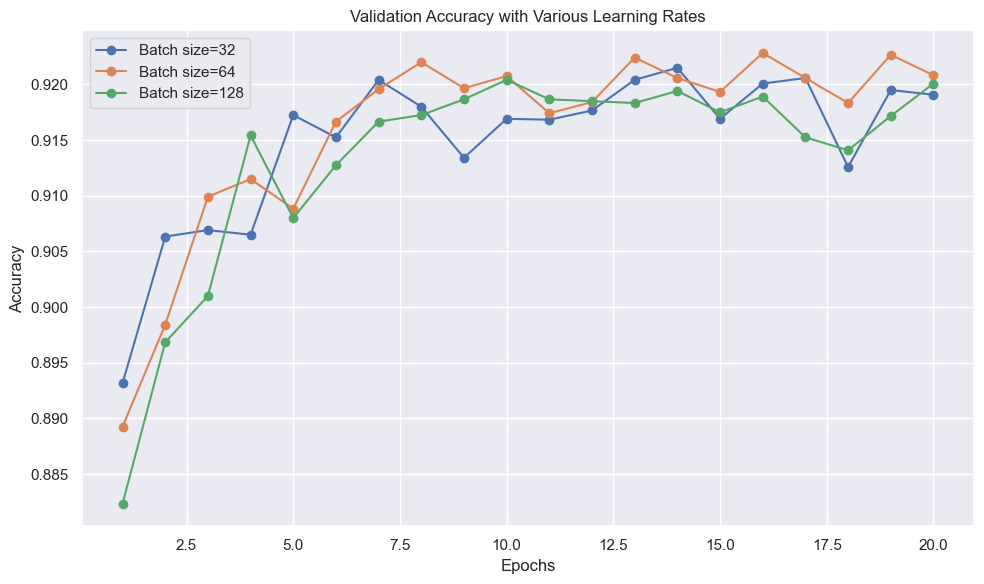

In [55]:
plt.figure(figsize=(10, 6))

for batch_size in batch_sizes:
    cnn_model = load_model(f'cnn_model_batch_{batch_size}')
    epochs = range(1, len(cnn_model.val_losses_cnn) + 1)
    plt.plot(epochs, cnn_model.val_accuracies_cnn, marker='o', label=f'Batch size={batch_size}')

plt.title('Validation Accuracy with Various Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


In [56]:
batch_size = 64
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True, generator=generator)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)
cnn = load_model('cnn_model_batch_64')
save_model(cnn, 'cnn_model_tuned')

Model loaded from saved_models/cnn_model_batch_64.pkl
Model saved to saved_models/cnn_model_tuned.pkl


### CNN Initialization and Training

In [ ]:
# Initialize CNN model and train
cnn = load_model('cnn_model_tuned')
if cnn is None: 
    learning_rate = 0.001
    cnn = CNN().to(device)
    optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    cnn.train_cnn(20, optimizer, loss_fn, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)
    save_model(cnn, 'cnn_model_tuned')


Model loaded from saved_models/cnn_model_tuned.pkl


### Plot results

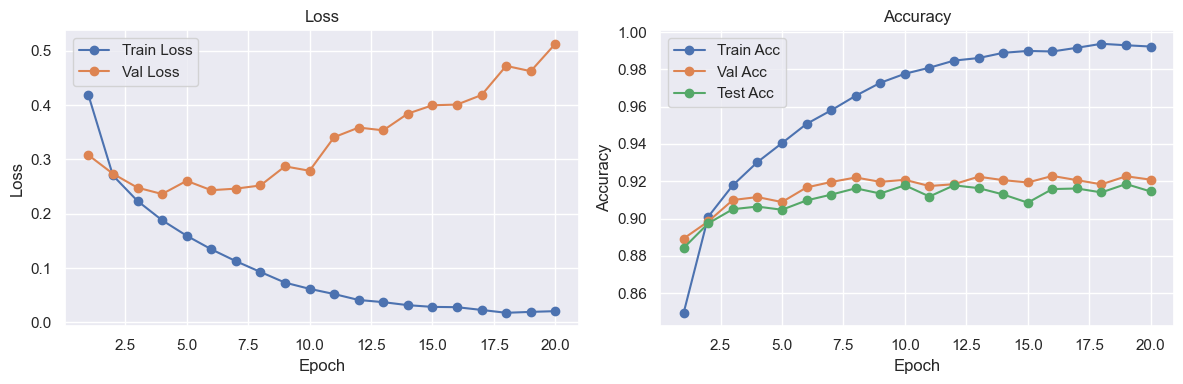

In [58]:
# Plot training/validation history
plt.figure(figsize=(12,4))

if cnn is None:
    raise ValueError("CNN model not loaded properly.")

plt.subplot(1,2,1)
plt.plot(range(1, cnn.num_epochs+1), cnn.train_losses_cnn, 'o-', label='Train Loss')
plt.plot(range(1, cnn.num_epochs+1), cnn.val_losses_cnn, 'o-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, cnn.num_epochs+1), cnn.train_accuracies_cnn,'o-', label='Train Acc')
plt.plot(range(1, cnn.num_epochs+1), cnn.val_accuracies_cnn, 'o-', label='Val Acc')
plt.plot(range(1, cnn.num_epochs+1), cnn.test_accuracies_cnn, 'o-', label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Results Confusion Matrix

(10, 10)


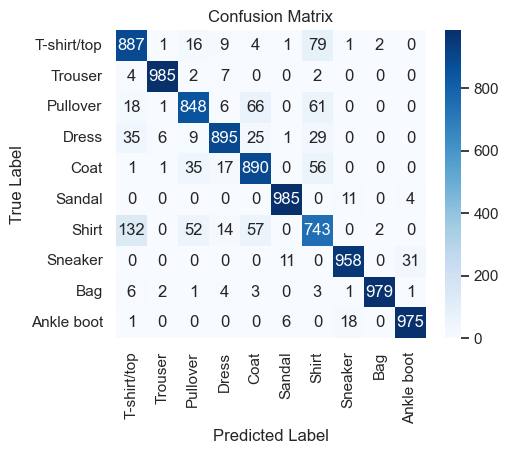

In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if cnn is None:
    raise ValueError("CNN model not loaded properly.")

cnn.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_cnn:
        images = images.to(device)
        outputs = cnn(images)
        # print(F.softmax(outputs, -1))
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=datasets.FashionMNIST.classes, yticklabels=datasets.FashionMNIST.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 3.7: CNN with Data Augmentation

In [72]:
cnn_transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train)
])

full_train_cnn_data_augmentation = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform_data_augmentation)
# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn_data_augmentation))
val_size = len(full_train_cnn_data_augmentation) - train_size
# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn_data_augmentation, _ = random_split(full_train_cnn_data_augmentation, [train_size, val_size], generator=generator)

batch_size = 64
train_loader_cnn_data_augmentation = DataLoader(train_dataset_cnn_data_augmentation, batch_size=batch_size, shuffle=True, generator=generator)

### CCN with data augmentation Initialization and Training

In [73]:
# Initialize CNN model with data augmentation and train
cnn_aug = None # load_model('cnn_model_tuned_augmented')
if cnn_aug is None:
    learning_rate = 0.001
    cnn_aug = CNN().to(device)
    optimizer = optim.Adam(cnn_aug.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    cnn_aug.train_cnn(20, optimizer, loss_fn, train_loader_cnn_data_augmentation, val_loader_cnn, test_loader_cnn, device)
    save_model(cnn_aug, 'cnn_model_tuned_augmented')

Epoch 1/20: Train loss=0.4574, Train acc=83.41%, Val loss=0.3364, Val acc=87.83%, Test acc=87.77%
Epoch 2/20: Train loss=0.2969, Train acc=89.19%, Val loss=0.2675, Val acc=90.17%, Test acc=89.54%
Epoch 3/20: Train loss=0.2546, Train acc=90.68%, Val loss=0.2417, Val acc=91.20%, Test acc=90.81%
Epoch 4/20: Train loss=0.2279, Train acc=91.45%, Val loss=0.2321, Val acc=91.53%, Test acc=90.93%
Epoch 5/20: Train loss=0.2046, Train acc=92.44%, Val loss=0.2231, Val acc=91.79%, Test acc=91.33%
Epoch 6/20: Train loss=0.1855, Train acc=93.13%, Val loss=0.2322, Val acc=91.68%, Test acc=91.65%
Epoch 7/20: Train loss=0.1722, Train acc=93.51%, Val loss=0.2070, Val acc=92.42%, Test acc=92.06%
Epoch 8/20: Train loss=0.1562, Train acc=94.23%, Val loss=0.2041, Val acc=92.64%, Test acc=92.43%
Epoch 9/20: Train loss=0.1435, Train acc=94.70%, Val loss=0.2080, Val acc=92.73%, Test acc=92.15%
Epoch 10/20: Train loss=0.1337, Train acc=95.05%, Val loss=0.2128, Val acc=93.04%, Test acc=92.37%
Epoch 11/20: Train 

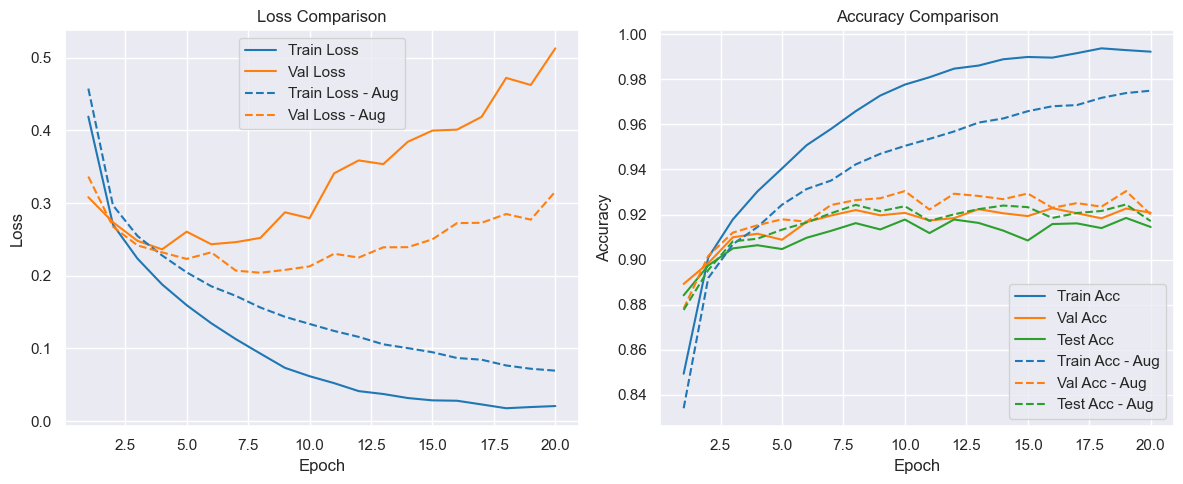

Training time without augmentation: 184.60 seconds
Training time with augmentation: 207.87 seconds


In [77]:
# Plot training/validation history of augmented CNN on top of original CNN
plt.figure(figsize=(12,5))
colors = ['tab:blue', 'tab:orange', 'tab:green']

if cnn is None:
    raise ValueError("CNN model not loaded properly.")

if cnn_aug is None:
    raise ValueError("CNN_Aug model not loaded properly.")

plt.subplot(1,2,1)
plt.plot(range(1, cnn.num_epochs+1), cnn.train_losses_cnn, label='Train Loss', color=colors[0])
plt.plot(range(1, cnn.num_epochs+1), cnn.val_losses_cnn, label='Val Loss', color=colors[1])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.train_losses_cnn, label='Train Loss - Aug', linestyle='--', color=colors[0])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.val_losses_cnn, label='Val Loss - Aug', linestyle='--', color=colors[1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, cnn.num_epochs+1), cnn.train_accuracies_cnn, label='Train Acc', color=colors[0])
plt.plot(range(1, cnn.num_epochs+1), cnn.val_accuracies_cnn, label='Val Acc', color=colors[1])
plt.plot(range(1, cnn.num_epochs+1), cnn.test_accuracies_cnn, label='Test Acc', color=colors[2])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.train_accuracies_cnn, label='Train Acc - Aug', linestyle='--', color=colors[0])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.val_accuracies_cnn, label='Val Acc - Aug', linestyle='--', color=colors[1])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.test_accuracies_cnn, label='Test Acc - Aug', linestyle ='--', color=colors[2])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compare training times
print(f"Training time without augmentation: {cnn.train_time:.2f} seconds")
print(f"Training time with augmentation: {cnn_aug.train_time:.2f} seconds")

In [79]:
cnn = load_model('cnn_model_tuned')
cnn_aug = load_model('cnn_model_tuned_augmented')

df = pd.DataFrame({
    "Epoch": list(range(1, 21)),
    "CNN Val Loss": cnn.val_losses_cnn,
    "CNN Test Acc": cnn.test_accuracies_cnn, 
    "CNN Aug Val Loss": cnn_aug.val_losses_cnn,
    "CNN Aug Test Acc": cnn_aug.test_accuracies_cnn
})

display(df)

Model loaded from saved_models/cnn_model_tuned.pkl
Model loaded from saved_models/cnn_model_tuned_augmented.pkl


,Epoch,CNN Val Loss,CNN Test Acc,CNN Aug Val Loss,CNN Aug Test Acc
0,1,0.307962,0.8842,0.336356,0.8777
1,2,0.273615,0.8974,0.267486,0.8954
2,3,0.247970,0.9050,0.241665,0.9081
3,4,0.236272,0.9064,0.232139,0.9093
4,5,0.260539,0.9047,0.223099,0.9133
5,6,0.243298,0.9097,0.232164,0.9165
6,7,0.246177,0.9128,0.207030,0.9206
7,8,0.252004,0.9162,0.204065,0.9243
8,9,0.287194,0.9134,0.208007,0.9215
9,10,0.279074,0.9178,0.212844,0.9237


## 3.8: Pretrained ResNet 

### Load ResNet18

In [65]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchinfo import summary
# Load a pre-trained ResNet-18 model
ResNet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
summary(ResNet18)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

### Prepare ResNet18 for Modification

In [66]:
# Freeze all convolutional layers
for param in ResNet18.parameters():
    param.requires_grad = False

# Modify First Layer for Grayscale Input
ResNet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Remove the fully connected layers (fc layer)
ResNet18.fc = nn.Identity() # Replace fc with identity # type: ignore
summary(ResNet18)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            3,136
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  (36,864)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  (36,864)
│    │    └─BatchNorm2d: 3-5             (128)
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  (36,864)
│    │    └─BatchNorm2d: 3-7             (128)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (36,864)
│    │    └─BatchNorm2d: 3-10            (128)
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11     

### Custom ResNet18 Class

In [70]:
import custom_ResNet
importlib.reload(custom_ResNet)     # reloads the module from disk
from custom_ResNet import CustomResNet18  # rebinds names in notebook namespace

In [68]:
# Device (use GPU if available but don't change MLP behavior)
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Using device:', device)

Using device: mps


### One layer added

In [ ]:
# Initialize CNN model and train
custom_resnet18_one_layers =  None #load_model('cnn_ResNet18_1_layers')
if custom_resnet18_one_layers is None: 
    learning_rate = 0.001
    num_classes = 10
    fc_layer = nn.Sequential(
        nn.Linear(512, num_classes)  # ResNet18's last feature map has 512 channels
    )
    custom_resnet18_one_layers = CustomResNet18(ResNet18, fc_layer).to(device)
    
    optimizer = optim.Adam(custom_resnet18_one_layers.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    custom_resnet18_one_layers.train_cnn(10, optimizer, loss_fn, 
                              train_loader_cnn_data_augmentation, 
                              test_loader_cnn_data_augmentation, device=device)
    save_model(custom_resnet18_one_layers, 'cnn_ResNet18_1_layers')

summary(custom_resnet18_one_layers)

Model loaded from saved_models/custom_resnet18_model.pkl


Layer (type:depth-idx)                        Param #
CustomResNet18                                --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,640

### Two layers added

In [ ]:
# Initialize CNN model and train
custom_resnet18_two_layers = None # load_model('custom_resnet18_model.2')
if custom_resnet18_two_layers is None: 
    learning_rate = 0.001
    custom_resnet18_two_layers = CustomResNet18(ResNet18, num_classes=10).to(device)
    optimizer = optim.Adam(custom_resnet18_two_layers.parameters(), lr=learning_rate)
    custom_resnet18_two_layers.fc_layers = nn.Sequential(
        nn.Linear(512, 256),  # ResNet18's last feature map has 512 channels
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
    loss_fn = nn.CrossEntropyLoss()
    custom_resnet18_two_layers.train_cnn(10, optimizer, loss_fn, 
                              train_loader_cnn_data_augmentation, 
                              test_loader_cnn_data_augmentation, device)
    save_model(custom_resnet18_two_layers, 'custom_resnet18_model.2')

summary(custom_resnet18_two_layers)

Model loaded from saved_models/custom_resnet18_model.pkl


Layer (type:depth-idx)                        Param #
CustomResNet18                                --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,640

### Three layers added

In [ ]:
# Initialize CNN model and train
custom_resnet18_three_layers = None # load_model('custom_resnet18_model.2')
if custom_resnet18_three_layers is None: 
    learning_rate = 0.001
    custom_resnet18_three_layers = CustomResNet18(ResNet18, num_classes=10).to(device)
    optimizer = optim.Adam(custom_resnet18_three_layers.parameters(), lr=learning_rate)
    custom_resnet18_three_layers.fc_layers = nn.Sequential(
        nn.Linear(512, 256),  # ResNet18's last feature map has 512 channels
        nn.ReLU(),
        nn.Linear(256, 128),  # ResNet18's last feature map has 512 channels
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )
    loss_fn = nn.CrossEntropyLoss()
    custom_resnet18_three_layers.train_cnn(10, optimizer, loss_fn, 
                              train_loader_cnn_data_augmentation, 
                              test_loader_cnn_data_augmentation, device)
    save_model(custom_resnet18_three_layers, 'custom_resnet18_model.2')

summary(custom_resnet18_three_layers)

### Custom ResNet18 Initialization and Training

In [ ]:
# Initialize CNN model and train
custom_resnet18 = load_model('custom_resnet18_model')
if custom_resnet18 is None: 
    learning_rate = 0.001
    custom_resnet18 = CustomResNet18(ResNet18, num_classes=10).to(device)
    optimizer = optim.Adam(custom_resnet18.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    custom_resnet18.train_cnn(20, optimizer, loss_fn, train_loader_cnn_data_augmentation, val_loader_cnn, test_loader_cnn, device)
    save_model(custom_resnet18, 'custom_resnet18_model')

summary(custom_resnet18)

RuntimeError: Invalid buffer size: 12.25 KiB

### Plot Results

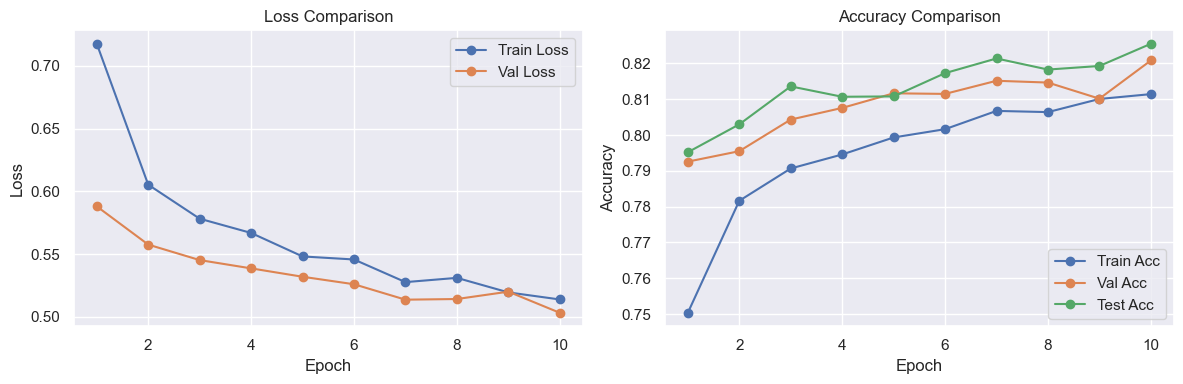

In [ ]:
# Plot training/validation history
plt.figure(figsize=(12,4))

if custom_resnet18 is None:
    raise ValueError("custom_resnet18 model not loaded properly.")

plt.subplot(1,2,1)
plt.plot(range(1, custom_resnet18.num_epochs+1), custom_resnet18.train_losses_cnn, 'o-', label='Train Loss')
plt.plot(range(1, custom_resnet18.num_epochs+1), custom_resnet18.val_losses_cnn, 'o-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, custom_resnet18.num_epochs+1), custom_resnet18.train_accuracies_cnn, 'o-', label='Train Acc')
plt.plot(range(1, custom_resnet18.num_epochs+1), custom_resnet18.val_accuracies_cnn, 'o-', label='Val Acc')
plt.plot(range(1, custom_resnet18.num_epochs+1), custom_resnet18.test_accuracies_cnn, 'o-', label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
custom_resnet18 = load_model('custom_resnet18_model')
print(custom_resnet18.test_accuracies_cnn)

Model loaded from saved_models/custom_resnet18_model.pkl
[0.7952, 0.803, 0.8136, 0.8107, 0.8108, 0.8173, 0.8214, 0.8183, 0.8193, 0.8255]


### Results Confusion Matrix

(10, 10)


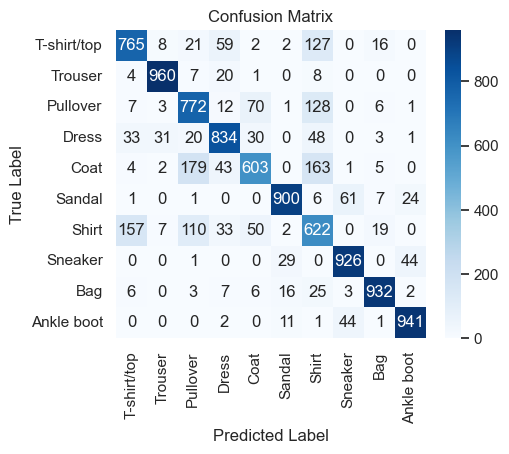

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if custom_resnet18 is None:
    raise ValueError("custom_resnet18 model not loaded properly.")

custom_resnet18.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_cnn_data_augmentation:
        images = images.to(device)
        outputs = custom_resnet18(images)
        # print(F.softmax(outputs, -1))
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=datasets.FashionMNIST.classes, yticklabels=datasets.FashionMNIST.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### One layer added

In [ ]:
# Initialize CNN model and train
custom_resnet18_one_layers =  None #load_model('custom_resnet18_model_1')
if custom_resnet18_one_layers is None: 
    learning_rate = 0.001
    num_classes = 10
    custom_resnet18_one_layers = CustomResNet18(ResNet18, num_classes=num_classes).to(device)
    custom_resnet18_one_layers.fc_layers = nn.Sequential(
        nn.Linear(512, num_classes)  # ResNet18's last feature map has 512 channels
    )
    
    optimizer = optim.Adam(custom_resnet18_one_layers.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    custom_resnet18_one_layers.train_cnn(10, optimizer, loss_fn, 
                              train_loader_cnn_data_augmentation, 
                              test_loader_cnn_data_augmentation, device)
    save_model(custom_resnet18_one_layers, 'custom_resnet18_model')

summary(custom_resnet18_one_layers)

Model loaded from saved_models/custom_resnet18_model.pkl


Layer (type:depth-idx)                        Param #
CustomResNet18                                --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,640

### Two layers added

In [ ]:
# Initialize CNN model and train
custom_resnet18_two_layers = None # load_model('custom_resnet18_model.2')
if custom_resnet18_two_layers is None: 
    learning_rate = 0.001
    custom_resnet18_two_layers = CustomResNet18(ResNet18, num_classes=10).to(device)
    optimizer = optim.Adam(custom_resnet18_two_layers.parameters(), lr=learning_rate)
    custom_resnet18_two_layers.fc_layers = nn.Sequential(
        nn.Linear(512, 256),  # ResNet18's last feature map has 512 channels
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
    loss_fn = nn.CrossEntropyLoss()
    custom_resnet18_two_layers.train_cnn(10, optimizer, loss_fn, 
                              train_loader_cnn_data_augmentation, 
                              test_loader_cnn_data_augmentation, device)
    save_model(custom_resnet18_two_layers, 'custom_resnet18_model.2')

summary(custom_resnet18_two_layers)

Model loaded from saved_models/custom_resnet18_model.pkl


Layer (type:depth-idx)                        Param #
CustomResNet18                                --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,640

### Three layers added

In [ ]:
# Initialize CNN model and train
custom_resnet18_three_layers = None # load_model('custom_resnet18_model.2')
if custom_resnet18_three_layers is None: 
    learning_rate = 0.001
    custom_resnet18_three_layers = CustomResNet18(ResNet18, num_classes=10).to(device)
    optimizer = optim.Adam(custom_resnet18_three_layers.parameters(), lr=learning_rate)
    custom_resnet18_three_layers.fc_layers = nn.Sequential(
        nn.Linear(512, 256),  # ResNet18's last feature map has 512 channels
        nn.ReLU(),
        nn.Linear(256, 128),  # ResNet18's last feature map has 512 channels
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )
    loss_fn = nn.CrossEntropyLoss()
    custom_resnet18_three_layers.train_cnn(10, optimizer, loss_fn, 
                              train_loader_cnn_data_augmentation, 
                              test_loader_cnn_data_augmentation, device)
    save_model(custom_resnet18_three_layers, 'custom_resnet18_model.2')

summary(custom_resnet18_three_layers)